In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
# scientific notation 해제
pd.set_option('display.float_format', '{:.2f}'.format)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import warnings; warnings.filterwarnings('ignore')
import missingno as msno
import pandas_profiling

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Interactive Data Lab/covid-19/원본/data.csv')
print(df.shape)
display(df.head(2))
print(df.isnull().sum().sort_values(ascending=False).head(10))

(151085, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.00,5.00,nan,nan,nan,nan,0.13,0.13,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8.33,39835428.00,54.42,18.60,2.58,1.34,1803.99,nan,597.03,9.59,nan,nan,37.75,0.50,64.83,0.51,nan,nan,nan,nan
1,AFG,Asia,Afghanistan,2020-02-25,5.00,0.00,nan,nan,nan,nan,0.13,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8.33,39835428.00,54.42,18.60,2.58,1.34,1803.99,nan,597.03,9.59,nan,nan,37.75,0.50,64.83,0.51,nan,nan,nan,nan


weekly_icu_admissions                      146832
weekly_icu_admissions_per_million          146832
excess_mortality_cumulative_per_million    145879
excess_mortality                           145879
excess_mortality_cumulative_absolute       145879
excess_mortality_cumulative                145879
weekly_hosp_admissions                     142553
weekly_hosp_admissions_per_million         142553
total_boosters_per_hundred                 139536
total_boosters                             139536
dtype: int64


## pandas profiling (로컬에서 진행했음)

In [ ]:
# # report
# report = df.profile_report()
# report.to_file('covid_report.html')

## 전처리

필요한 Columns
<br><br> 
**1. Confirmed cases**
* total_cases : 전체 확진자 수
* new_caes : 신규 확진자 수

**2. Confirmed deaths**
* total_deaths : 전체 사망자 수
* new_deaths : 신규 사망자 수

**3. Policy responses**
* stringency_index : 정부대응강화지수(휴업, 직장 폐업, 출장 금지 등 9개의 대응지표를 바탕으로 종합 대책을 0~100으로 나타냄(Oxford Covid-19 Government Response Tracker)

**4. Reproduction rate**
* reproduction_rate : 감염병의 유효 재생산수를 추정하기 위한 방법. SIR 모델에서 covid-19이 감염자 수의 증가율과 선형 관계에 있다는 사실에 기초함 (Kalman Filter를 이용한 새로운 실시간 추정치, [관련 저널: Tracking R of COVID-19: A new real-time estimation using the Kalman filter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0244474))

**5. Vaccinations**
* total_vaccinations : 총 백신 접종 용량
* people_vaccinated : 최소한 1회 이상의 백신을 접종한 사람 수 (total)
* people_fully_vaccinated : 예방접종 프로토콜에 따른 백신 횟수를 모두 접종한 사람 수 (total)
* total_boosters : 투여된 백신 부스터 용량 (예방접종 프로토콜에서 규정한 수보다 많이 투여된 용량)
* new_vaccinations : 새로 접종된 백신 용량(연속 일수만 계산)

**6. Hospital & ICU**
* icu_patients : 특정일에 중환자실에 있는 covid-19 환자 수
* hosp_patients : 특정일에 병원에 있는 covid-19 환자 수 

**7. Others**
* continent
* location
* date (연월일)
* population
* population_density : 인구밀도(인구 수를 평당 킬로미터로 나눈 값)
* median_age : 2020년 전체 인구의 연령 중위값(중간값)
* aged_65_older: 65세 이상의 인구 비율(가장 최근 연도)
* aged_70_older : 70세 이상의 인구 비율(2015년)
* gdp_per_capita : 구매력 평가 기준 국내 총생산(2011년 국제 달러 고정)(가장 최근 연도)
* extreme_poverty : 극빈층 인구 비율(2010년 이후 가장 최근 연도)
* cardiovasc_death_rate : 2017년 심혈관계 질환 사망률(인구 10만 명당 연간 사망자 수
* diabetes_prevalence : 20~79세의 당뇨병 유병률(2017년)
* female_smokers : 여성 흡연자 비율(가장 최근 연도)
* male_smokers : 남성 흡연자 비율(가장 최근 연도)
* handwashing_facilities : 지역에 기본적인 손 씻는 시설을 갖춘 인구 비율(가장 최근 연도)
* hospital_beds_per_thousand : 인구 1,000명당 병상 개수(2010년 이후 가장 최근 연도)
* life_expectancy : 기대수명(2019년)
* human_development_index : 인간 성장의 가장 기본적인 3가지 차원(길고 건강한 삶, 지식, 적절한 생활 수준)의 평균 성취도를 측정하는 종합 지수(2019년)([관련 링크](http://hdr.undp.org/en/indicators/137506))

In [5]:
# 필요 컬럼만 남기고 제거
col = ['iso_code', 'continent', 'location', 'date', 
       'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations', 'total_boosters',
       'stringency_index', 'reproduction_rate', 'icu_patients', 'hosp_patients',
       'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities',
       'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']
data = df[col]

## simple EDA

### 결측치 

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_boosters,stringency_index,reproduction_rate,icu_patients,hosp_patients,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,5.00,5.00,nan,nan,nan,nan,nan,nan,nan,8.33,nan,nan,nan,39835428.00,54.42,18.60,2.58,1.34,1803.99,nan,597.03,9.59,nan,nan,37.75,0.50,64.83,0.51
1,AFG,Asia,Afghanistan,2020-02-25,5.00,0.00,nan,nan,nan,nan,nan,nan,nan,8.33,nan,nan,nan,39835428.00,54.42,18.60,2.58,1.34,1803.99,nan,597.03,9.59,nan,nan,37.75,0.50,64.83,0.51
2,AFG,Asia,Afghanistan,2020-02-26,5.00,0.00,nan,nan,nan,nan,nan,nan,nan,8.33,nan,nan,nan,39835428.00,54.42,18.60,2.58,1.34,1803.99,nan,597.03,9.59,nan,nan,37.75,0.50,64.83,0.51
3,AFG,Asia,Afghanistan,2020-02-27,5.00,0.00,nan,nan,nan,nan,nan,nan,nan,8.33,nan,nan,nan,39835428.00,54.42,18.60,2.58,1.34,1803.99,nan,597.03,9.59,nan,nan,37.75,0.50,64.83,0.51
4,AFG,Asia,Afghanistan,2020-02-28,5.00,0.00,nan,nan,nan,nan,nan,nan,nan,8.33,nan,nan,nan,39835428.00,54.42,18.60,2.58,1.34,1803.99,nan,597.03,9.59,nan,nan,37.75,0.50,64.83,0.51


(151085, 32)


<Figure size 360x360 with 0 Axes>

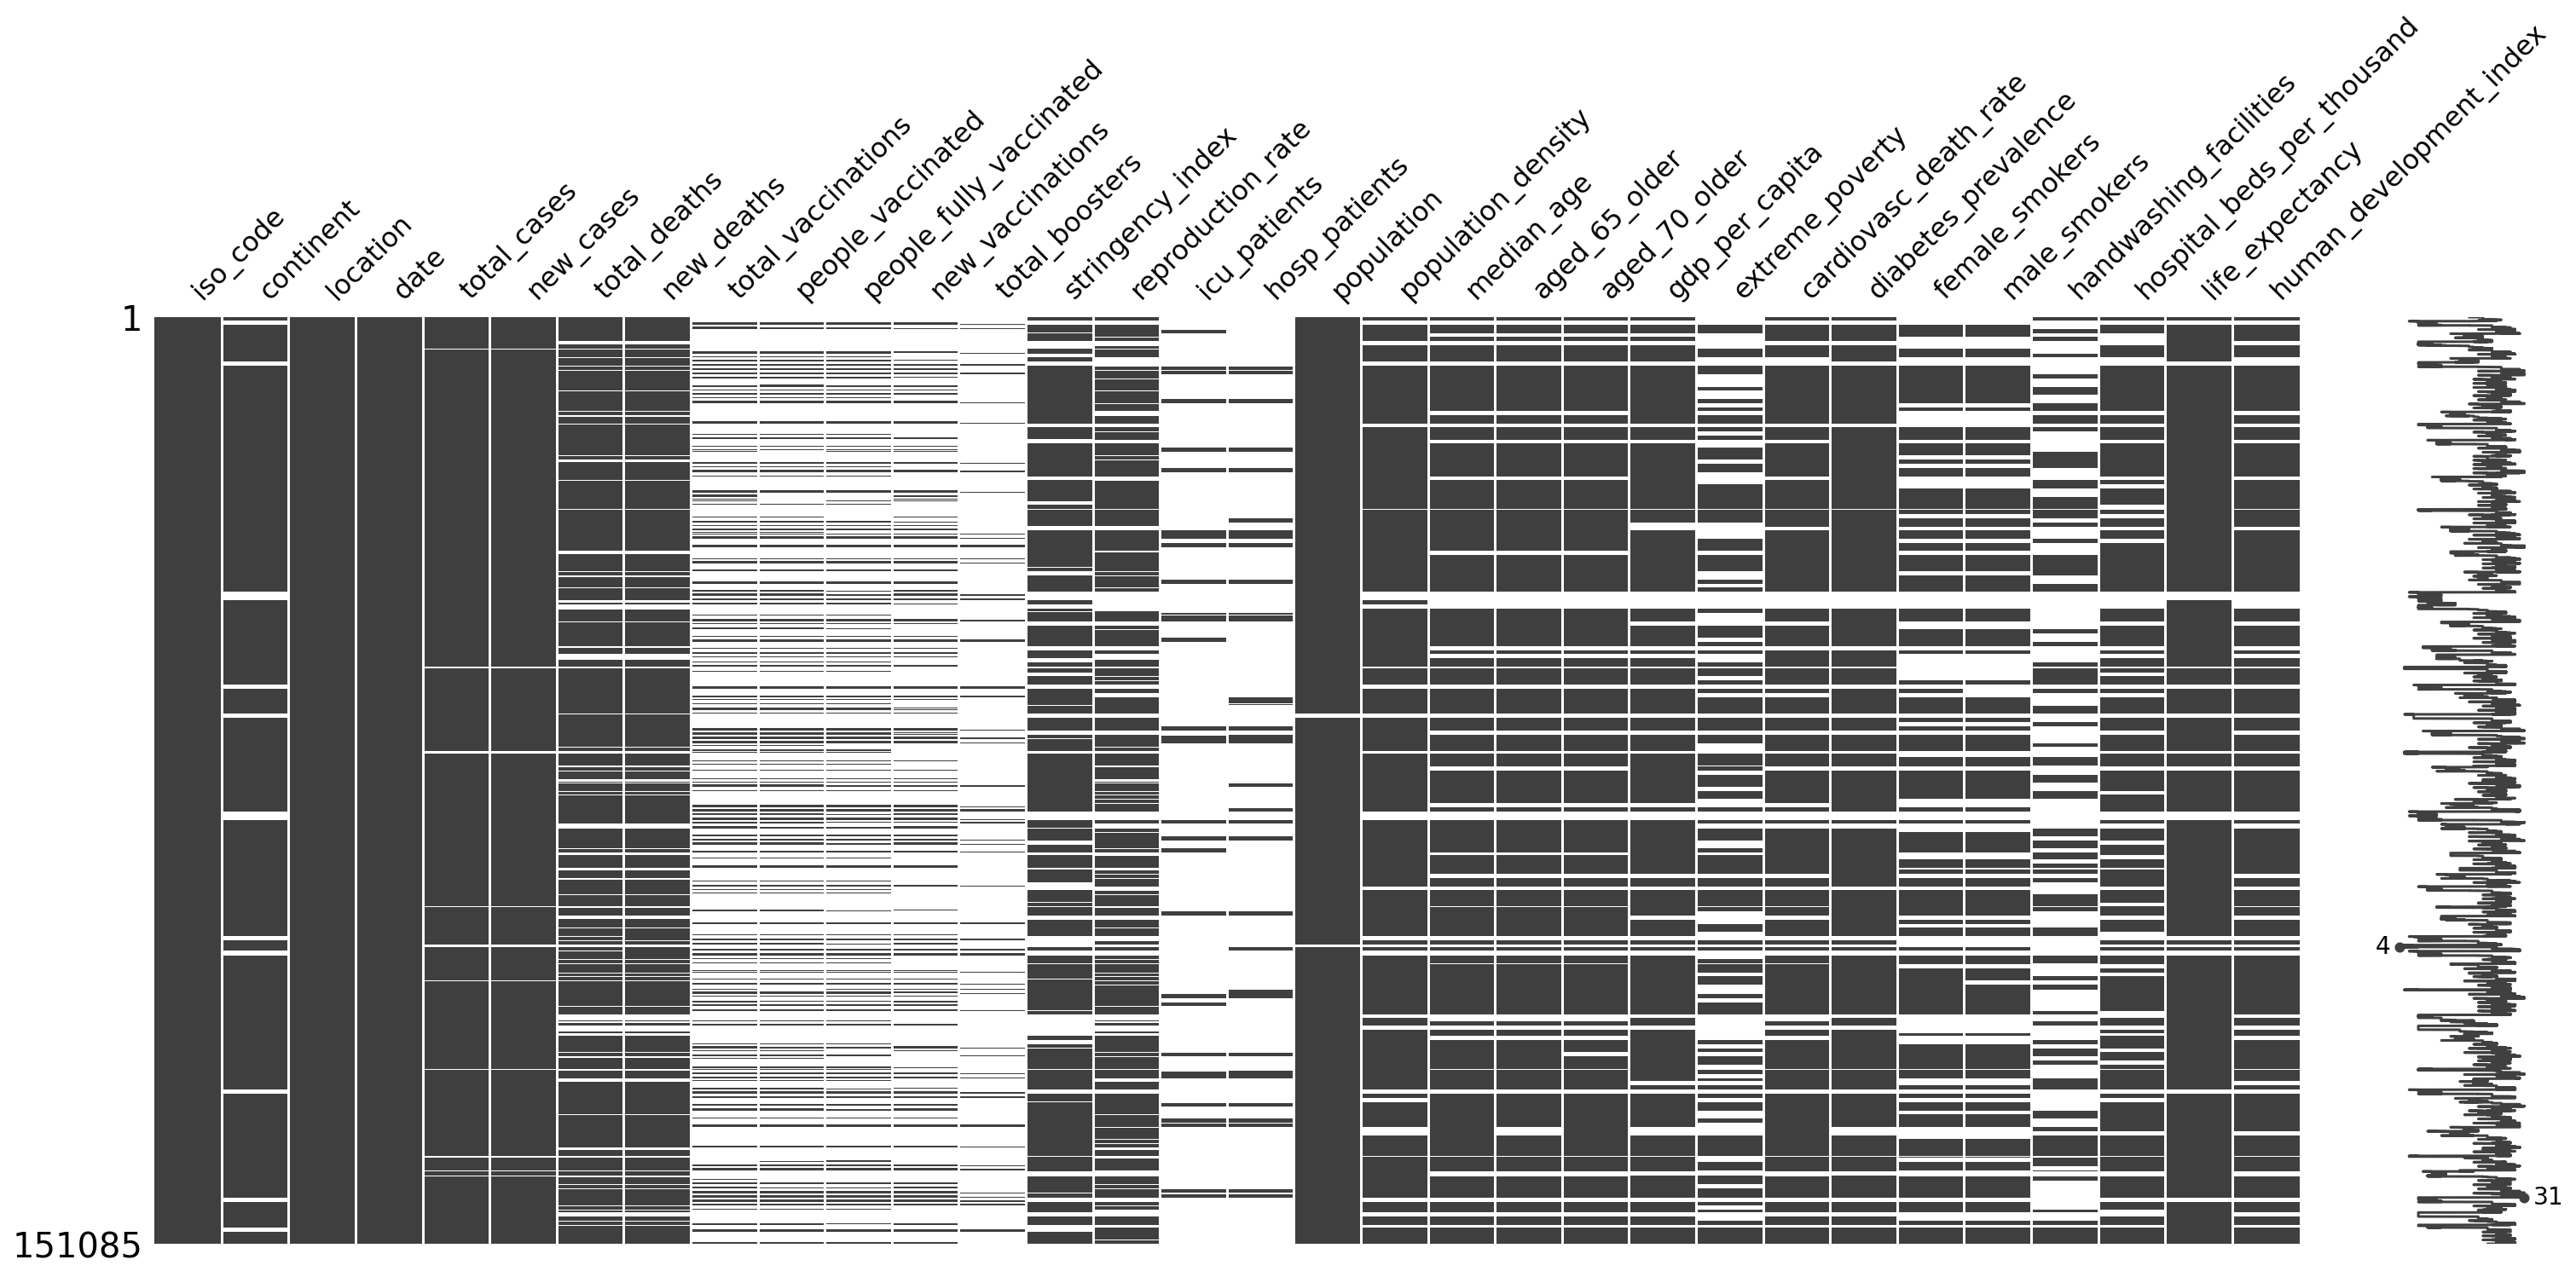

In [14]:
display(data.head())
print(data.shape)
plt.figure(figsize=(5, 5))
display(msno.matrix(data))

In [7]:
# 컬럼별 결측치 개수(내림차순 정렬)
# 결측치란 null data, 즉 데이터가 없는 비어있는 값을 의미합니다.
data.isnull().sum().sort_values(ascending=True).plot.barh(
                                                            figsize=(10, 8),
                                                            title='null data (sort in descending order)'
                                                            )

결측치가 많은 컬럼들이 존재하지만 해당 데이터에서의 결측치는 그냥 drop 해서는 안됨  
* 예를 들어, 결측치가 가장 많은 컬럼인 total_boosters는 부스터샷 접종이 진행된 용량(doses)을 의미하는데 이 컬럼이 null인 국가의 해당일에는 아무도 부스터샷을 접종하지 않았음을 의미 -> 이것 역시 우리의 분석 및 시각화에서 매우 유의미한 지표
* 그 외의 컬럼들 중에서도 위와 같이 '유의미한 결측치'인 경우들이 많으므로 위 데이터에 포함된 결측치를 따로 제거하지 않음
* **단, 팀원 각자가 시각화를 진행하면서 결측치를 어떻게 처리할지의 유무는 각자가 판단하시면 좋을 것 같습니다. 각자의 해석의 영역이 있을 것이기 때문에 데이터 전처리 과정에서는 모든 결측치를 그대로 살려두겠습니다.**

### 각 컬럼에 대한 very simple eda

In [8]:
def description(df):
    
    print('numerical data description')
    display(df.describe())
    print('object data description')
    display(df.describe(include='object'))

description(data)

numerical data description


,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_boosters,stringency_index,reproduction_rate,icu_patients,hosp_patients,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
count,148470.00,148436.00,131344.00,131523.00,38217.00,36717.00,33921.00,31651.00,11549.00,117538.00,113675.00,18476.00,20299.00,150075.00,134507.00,125524.00,124160.00,124850.00,125928.00,83133.00,124536.00,130917.00,96463.00,95073.00,62367.00,112517.00,141018.00,124011.00
mean,2094697.34,8083.00,52079.53,171.24,135251858.85,71601884.95,52588971.97,1132854.26,6871673.82,55.45,1.00,870.64,4088.53,148600618.63,465.30,30.59,8.77,5.54,19692.44,13.54,259.79,8.18,10.58,32.76,50.82,3.03,73.60,0.73
std,12418600.49,45261.19,274035.87,834.07,621089107.26,334932088.12,259335422.09,4261576.16,30570983.24,20.60,0.35,2725.64,11087.43,708390787.81,2149.78,9.10,6.15,4.19,20670.93,20.00,119.81,4.46,10.50,13.52,31.81,2.45,7.49,0.15
min,1.00,-74347.00,1.00,-1918.00,0.00,0.00,1.00,0.00,1.00,0.00,-0.03,0.00,0.00,47.00,0.14,15.10,1.14,0.53,661.24,0.10,79.37,0.99,0.10,7.70,1.19,0.10,53.28,0.39
25%,1521.00,1.00,67.00,0.00,474743.00,323837.00,209009.00,6674.50,134.00,41.20,0.83,25.00,126.00,1273428.00,36.25,22.20,3.51,2.06,4466.51,0.60,168.71,5.31,1.90,21.60,19.35,1.30,69.50,0.60
50%,19978.50,68.00,663.00,2.00,3655546.00,2284343.00,1665947.00,40218.00,84523.00,56.02,1.00,128.00,631.00,8715494.00,85.13,29.90,6.61,3.92,12951.84,2.20,242.65,7.17,6.30,31.40,49.84,2.40,75.05,0.74
75%,251151.25,908.00,6379.00,19.00,22288819.00,13646933.00,9555944.00,265856.00,1670204.00,71.30,1.17,534.25,2712.50,33933611.00,212.87,39.10,14.18,8.68,27936.90,21.20,329.94,10.43,19.30,41.30,83.24,4.00,78.93,0.84
max,286523281.00,1992628.00,5429324.00,18062.00,9097104632.00,4573795231.00,3856295888.00,55059824.00,504769303.00,100.00,5.92,28891.00,133268.00,7874965730.00,20546.77,48.20,27.05,18.49,116935.60,77.60,724.42,30.53,44.00,78.10,100.00,13.80,86.75,0.96


object data description


,iso_code,continent,location,date
count,151085,141974,151085,151085
unique,238,6,238,730
top,ARG,Africa,Peru,2021-08-22
freq,730,35842,730,237


* 위의 기술통계 요약 내용을 보면 조금 이상한 부분들 존재 (ex. 최솟값(min)이 마이너스인 경우 -> new_cases, total_deaths)
* reproduction_rate 역시 최솟값이 -0.03으로 음수이지만 칼만 필터 활용한 수식의 결과값이 0보다 작을 수 있다고 판단했음.

In [9]:
# new_cases가 음수인 경우
display(data[data['new_cases'] < 0 ].head())
new_cases_minus_len = len(data[data['new_cases'] < 0 ])
print(f"신규 확진자 수가 음수인 경우: {new_cases_minus_len}개")

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_boosters,stringency_index,reproduction_rate,icu_patients,hosp_patients,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
25,AFG,Asia,Afghanistan,2020-03-20,24.00,-2.00,nan,nan,nan,nan,nan,nan,nan,41.67,nan,nan,nan,39835428.00,54.42,18.60,2.58,1.34,1803.99,nan,597.03,9.59,nan,nan,37.75,0.50,64.83,0.51
4788,ATG,North America,Antigua and Barbuda,2020-07-03,68.00,-1.00,3.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,98728.00,231.84,32.10,6.93,4.63,21490.94,nan,191.51,13.17,nan,nan,nan,3.80,77.02,0.78
5098,ATG,North America,Antigua and Barbuda,2021-05-09,1231.00,-1.00,32.00,0.00,nan,nan,nan,nan,nan,nan,0.42,nan,nan,98728.00,231.84,32.10,6.93,4.63,21490.94,nan,191.51,13.17,nan,nan,nan,3.80,77.02,0.78
10755,BHS,North America,Bahamas,2021-11-10,22544.00,-48.00,661.00,0.00,nan,nan,nan,nan,nan,39.35,0.91,nan,nan,396914.00,39.50,34.30,9.00,5.20,27717.85,nan,235.95,13.17,3.10,20.40,nan,2.90,73.92,0.81
14884,BEN,Africa,Benin,2020-05-19,130.00,-209.00,2.00,0.00,nan,nan,nan,nan,nan,57.41,1.09,nan,nan,12451031.00,99.11,18.80,3.24,1.94,2064.24,49.60,235.85,0.99,0.60,12.30,11.04,0.50,61.77,0.55


신규 확진자 수가 음수인 경우: 97개


In [10]:
# Bahamas의 신규확진자가 음수가 나왔던 날의 전후를 짧게 확인
data.iloc[10753:10756, :]

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_boosters,stringency_index,reproduction_rate,icu_patients,hosp_patients,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
10753,BHS,North America,Bahamas,2021-11-08,22529.00,44.00,661.00,4.00,nan,nan,nan,nan,nan,39.35,0.89,nan,nan,396914.00,39.50,34.30,9.00,5.20,27717.85,nan,235.95,13.17,3.10,20.40,nan,2.90,73.92,0.81
10754,BHS,North America,Bahamas,2021-11-09,22592.00,63.00,661.00,0.00,nan,nan,nan,nan,nan,39.35,0.90,nan,nan,396914.00,39.50,34.30,9.00,5.20,27717.85,nan,235.95,13.17,3.10,20.40,nan,2.90,73.92,0.81
10755,BHS,North America,Bahamas,2021-11-10,22544.00,-48.00,661.00,0.00,nan,nan,nan,nan,nan,39.35,0.91,nan,nan,396914.00,39.50,34.30,9.00,5.20,27717.85,nan,235.95,13.17,3.10,20.40,nan,2.90,73.92,0.81


* 21년 11월 10일 신규 확진자가 -48이 되면서 실제로 전체 확진자 수가 전날(11/9)에 비해 48명 적어진 것을 확인
* JHU CSSE covid-19 data (https://www.google.com/search?q=New+confirmed+cases+of+COVID-19&oq=New+confirmed+cases+of+COVID-19&aqs=chrome..69i57j69i60l3.775j0j7&sourceid=chrome&ie=UTF-8)에서 확인한 결과, 11/10 신규 확진자 수는 0명
* 다른 케이스들도 추가적으로 확인 진행

In [31]:
# 아프리카 베냉 확인
data.iloc[14881:14887, :]

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_boosters,stringency_index,reproduction_rate,icu_patients,hosp_patients,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
14881,BEN,Africa,Benin,2020-05-16,339.00,0.00,2.00,0.00,nan,nan,nan,nan,nan,57.41,1.09,nan,nan,12451031.00,99.11,18.80,3.24,1.94,2064.24,49.60,235.85,0.99,0.60,12.30,11.04,0.50,61.77,0.55
14882,BEN,Africa,Benin,2020-05-17,339.00,0.00,2.00,0.00,nan,nan,nan,nan,nan,62.96,1.09,nan,nan,12451031.00,99.11,18.80,3.24,1.94,2064.24,49.60,235.85,0.99,0.60,12.30,11.04,0.50,61.77,0.55
14883,BEN,Africa,Benin,2020-05-18,339.00,0.00,2.00,0.00,nan,nan,nan,nan,nan,57.41,1.09,nan,nan,12451031.00,99.11,18.80,3.24,1.94,2064.24,49.60,235.85,0.99,0.60,12.30,11.04,0.50,61.77,0.55
14884,BEN,Africa,Benin,2020-05-19,130.00,-209.00,2.00,0.00,nan,nan,nan,nan,nan,57.41,1.09,nan,nan,12451031.00,99.11,18.80,3.24,1.94,2064.24,49.60,235.85,0.99,0.60,12.30,11.04,0.50,61.77,0.55
14885,BEN,Africa,Benin,2020-05-20,130.00,0.00,2.00,0.00,nan,nan,nan,nan,nan,57.41,1.09,nan,nan,12451031.00,99.11,18.80,3.24,1.94,2064.24,49.60,235.85,0.99,0.60,12.30,11.04,0.50,61.77,0.55
14886,BEN,Africa,Benin,2020-05-21,135.00,5.00,3.00,1.00,nan,nan,nan,nan,nan,57.41,1.09,nan,nan,12451031.00,99.11,18.80,3.24,1.94,2064.24,49.60,235.85,0.99,0.60,12.30,11.04,0.50,61.77,0.55


* JHU CSSE covid-19 data에서 확인한 결과, 20년 5월 19일 역시 신규 확진자는 0명이었음
* 다만, 음수값들을 단순히 전부 0으로 치환할 수는 없음

---
***음수 값들에 대한 데이터 수집측의 설명***  
the number of cases or deaths reported by any institution—including JHU, the WHO, the ECDC and others—on a given day does not necessarily represent the actual number on that date.  
This is because of the long reporting chain that exists between a new case/death and its inclusion in statistics. This also means that negative values in cases and deaths can sometimes appear when a country corrects historical data, because it had previously overestimated the number of cases/deaths.  
Alternatively, large changes can sometimes (although rarely) be made to a country's entire time series if JHU decides (and has access to the necessary data) to correct values retrospectively.
* 요약하면, 이전에 세계 각국이 코로나 환자와 사망자 수를 과대 추정하면서 발생했던 오차를 이후에 수정하는 과정에서 음수 값이 나타날 수 있음.
* 따라서, 음수 값을 임의적으로 0으로 치환하지 않고 그대로 유지

#### iso_code

In [26]:
# iso_code 컬럼의 값들이 각각 몇 개씩 존재하는지
print(f"iso_code의 유니크 값 개수: {data['iso_code'].nunique()} \n238종류의 iso_code 존재\n")
data['iso_code'].value_counts().sort_values(ascending=False).to_frame().T

iso_code의 유니크 값 개수: 238 
238종류의 iso_code 존재



,ARG,PER,MEX,THA,TWN,KOR,CHN,OWID_UMC,JPN,OWID_ASI,OWID_LMC,OWID_NAM,USA,OWID_WRL,OWID_HIC,MAC,SGP,HKG,OWID_EUN,OWID_EUR,VNM,MYS,FRA,NPL,OWID_OCE,AUS,CAN,DEU,KHM,LKA,ARE,FIN,IND,FJI,PHL,ITA,RUS,GBR,ESP,SWE,DNK,SVN,EST,BEL,ZAF,MAR,OWID_INT,OWID_AFR,EGY,GTM,IRN,ISR,LBN,OWID_SAM,CHL,PRT,OWID_LIC,GRC,BHR,IRQ,OMN,LUX,KWT,AFG,ALB,PAK,CHE,DZA,HRV,AUT,ROU,GEO,NOR,MKD,SRB,BRA,LVA,ISL,NLD,NZL,SEN,BLR,NGA,LTU,MCO,IRL,QAT,SMR,DOM,ARM,ECU,AZE,CZE,SAU,IDN,AND,UKR,HUN,JOR,BGD,POL,GIB,TGO,LBY,FRO,TUN,LIE,PSE,MLT,BIH,CRI,BTN,SVK,COL,KEN,CMR,VAT,PRY,BGR,MDV,MDA,CYP,BRN,PAN,MNG,BFA,BOL,HND,CIV,COD,JAM,TUR,GUY,CUB,GIN,ATG,CYM,KAZ,SDN,URY,PYF,ABW,ETH,LCA,NAM,RWA,VCT,MRT,CUW,TTO,VEN,SUR,GAB,OWID_KOS,GHA,SWZ,GNQ,COG,UZB,SYC,CAF,BHS,TZA,GRL,SOM,BEN,LBR,MNE,GMB,BRB,MSR,KGZ,DJI,ZMB,MUS,TCD,BMU,NIC,NCL,SLV,IMN,AGO,CPV,MDG,PNG,HTI,ZWE,NER,ERI,UGA,SYR,DMA,MOZ,TLS,GRD,BLZ,LAO,GNB,KNA,MLI,MMR,VGB,TCA,AIA,MWI,BWA,SLE,BDI,BES,FLK,SPM,SSD,STP,YEM,COM,TJK,LSO,SHN,SLB,WLF,MHL,VUT,WSM,FSM,GGY,OWID_CYN,JEY,TON,SXM,KIR,COK,TKM,TUV,NRU,PLW,TKL,PCN,NIU
iso_code,730,730,730,727,715,710,709,709,709,709,709,709,709,709,709,709,708,708,708,708,708,707,707,706,706,705,705,704,704,704,702,702,701,701,701,700,700,700,699,699,698,698,697,696,693,693,693,687,686,683,681,680,679,678,677,677,677,677,676,676,676,676,676,676,675,675,675,675,675,675,674,674,674,674,674,674,674,673,673,672,672,672,672,671,671,671,671,671,670,670,670,670,670,669,669,669,668,668,668,668,667,667,667,667,667,667,667,666,666,666,665,665,665,665,665,665,665,664,663,663,663,663,662,662,661,661,660,660,660,660,660,660,659,659,658,658,658,658,658,658,658,658,658,657,657,657,657,657,657,657,657,657,657,657,657,657,656,656,656,656,656,655,655,655,655,655,654,654,654,654,653,653,653,653,653,652,652,652,652,652,651,651,651,651,651,651,651,651,650,650,649,649,649,649,649,648,647,646,646,646,644,643,643,643,642,641,640,640,638,636,635,635,634,630,610,609,597,480,445,438,429,416,408,344,325,317,281,255,231,227,224,183,179,146,131,114,85,43


#### continent

In [36]:
# continent 컬럼의 각 값이 전체 데이터에서 자치하는 비중
dd = data['continent'].value_counts().to_frame()
dd['percent(%)'] = dd.apply(lambda x: x/x.sum(), axis=0) * 100
dd['percent(%)'] = dd['percent(%)'].apply(lambda x: round(x, 2))
dd.style.background_gradient(cmap='Blues')

,continent,percent(%)
Africa,35842,25.250000
Europe,33764,23.780000
Asia,33054,23.280000
North America,22654,15.960000
South America,8737,6.150000
Oceania,7923,5.580000


#### location

In [73]:
# locatoin 컬럼의 describe output
# unique = 238   --> 유니크한 값이 238개라는 의미 (데이터에 238개의 location이 존재)
# top = Argentina(freq=730)  --> location 컬럼에서 가장 많이 등장하는 location은 아르헨티나(730번 등장)
data['location'].describe().to_frame()

,location
count,151085
unique,238
top,Argentina
freq,730


In [97]:
# 730번 등장하는 지역이 아르헨티나 말고는 없을까?
# 멕시코와 페루도 아르헨티나처럼 730번 등장하는 지역
data.loc[data['location'].isin(data['location'].value_counts().loc[data['location'].value_counts() == 730].index.tolist()),
                                                                                            ['iso_code', 'continent', 'location']].drop_duplicates(['iso_code', 'continent', 'location'])

,iso_code,continent,location
5334,ARG,South America,Argentina
89115,MEX,North America,Mexico
108206,PER,South America,Peru


#### date

In [48]:
print(f"데이터에 적재되어 있는 기간: {min(data['date'])}~{max(data['date'])}\n")

# 국가별 적재되어 있는 기간
location_date = data.groupby(['location'])['date'].agg(['min', 'max'])
location_date.T

데이터에 적재되어 있는 기간: 2020-01-01~2021-12-30



location,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,Asia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bonaire Sint Eustatius and Saba,Bosnia and Herzegovina,Botswana,Brazil,British Virgin Islands,Brunei,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Cayman Islands,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo,Cook Islands,Costa Rica,Cote d'Ivoire,Croatia,Cuba,Curacao,Cyprus,Czechia,Democratic Republic of Congo,Denmark,Djibouti,Dominica,Dominican Republic,Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Eswatini,Ethiopia,Europe,European Union,Faeroe Islands,Falkland Islands,Fiji,Finland,France,French Polynesia,Gabon,Gambia,Georgia,Germany,Ghana,Gibraltar,Greece,Greenland,Grenada,Guatemala,Guernsey,Guinea,Guinea-Bissau,Guyana,Haiti,High income,Honduras,Hong Kong,Hungary,Iceland,India,Indonesia,International,Iran,Iraq,Ireland,Isle of Man,Israel,Italy,Jamaica,Japan,Jersey,Jordan,Kazakhstan,Kenya,Kiribati,Kosovo,Kuwait,Kyrgyzstan,Laos,Latvia,Lebanon,Lesotho,Liberia,Libya,Liechtenstein,Lithuania,Low income,Lower middle income,Luxembourg,Macao,Madagascar,Malawi,Malaysia,Maldives,Mali,Malta,Marshall Islands,Mauritania,Mauritius,Mexico,Micronesia (country),Moldova,Monaco,Mongolia,Montenegro,Montserrat,Morocco,Mozambique,Myanmar,Namibia,Nauru,Nepal,Netherlands,New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Niue,North America,North Macedonia,Northern Cyprus,Norway,Oceania,Oman,Pakistan,Palau,Palestine,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Pitcairn,Poland,Portugal,Qatar,Romania,Russia,Rwanda,Saint Helena,Saint Kitts and Nevis,Saint Lucia,Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Samoa,San Marino,Sao Tome and Principe,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Sint Maarten (Dutch part),Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South America,South Korea,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan,Tajikistan,Tanzania,Thailand,Timor,Togo,Tokelau,Tonga,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,Turks and Caicos Islands,Tuvalu,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Upper middle income,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,World,Yemen,Zambia,Zimbabwe
min,2020-02-24,2020-02-13,2020-02-25,2020-02-25,2020-03-02,2020-03-20,2020-03-28,2020-03-13,2020-01-01,2020-03-01,2020-03-13,2020-01-22,2020-01-26,2020-02-25,2020-03-01,2020-03-16,2020-02-24,2020-03-03,2020-03-17,2020-02-28,2020-02-04,2020-03-23,2020-03-16,2020-03-19,2020-03-06,2020-03-11,2020-04-02,2020-03-05,2020-03-30,2020-02-26,2020-03-28,2020-03-09,2020-03-08,2020-03-10,2020-03-31,2020-01-27,2020-03-06,2020-01-26,2020-03-20,2020-03-13,2020-03-15,2020-03-19,2020-02-23,2020-01-22,2020-03-06,2020-04-30,2020-03-15,2021-05-21,2020-03-06,2020-03-11,2020-02-25,2020-03-12,2020-03-14,2020-03-08,2020-03-01,2020-03-11,2020-02-02,2020-03-18,2020-03-22,2020-03-01,2020-03-01,2020-02-14,2020-03-19,2020-03-15,2020-03-21,2020-01-06,2020-03-14,2020-03-13,2020-01-23,2020-01-23,2020-03-04,2020-04-04,2020-01-30,2020-01-29,2020-01-24,2020-03-13,2020-03-14,2020-03-17,2020-02-26,2020-01-27,2020-03-14,2020-03-04,2020-01-06,2020-03-16,2020-03-22,2020-02-17,2021-01-24,2020-03-13,2020-03-25,2020-03-12,2020-03-20,2020-01-22,2020-03-11,2020-01-23,2020-03-03,2020-02-27,2020-01-30,2020-03-02,2020-02-07,2020-02-19,2020-02-24,2020-02-29,2020-03-20,2020-02-20,2020-01-31,2020-03-11,2020-01-22,2021-03-14,2020-03-03,2020-03-13,2020-03-06,2021-05-18,2020-03-14,2020-02-24,2020-03-18,2020-03-24,2020-01-06,2020-02-21,2020-05-13,2020-03-17,2020-03-04,2020-03-04,2020-02-29,2020-02-23,2020-01-22,2020-02-24,2020-01-22,2020-03-20,2020-03-29,2020-01-24,2020-03-08,2020-03-25,2020-03-05,2020-10-28,2020-03-14,2020-03-18,2020-01-01,2021-01-21,2020-03-08,2020-02-29,2020-03-10,2020-03-17,2020-03-18,2020-02-07,2020

#### total_cases, new_cases, total_deaths, new_deaths

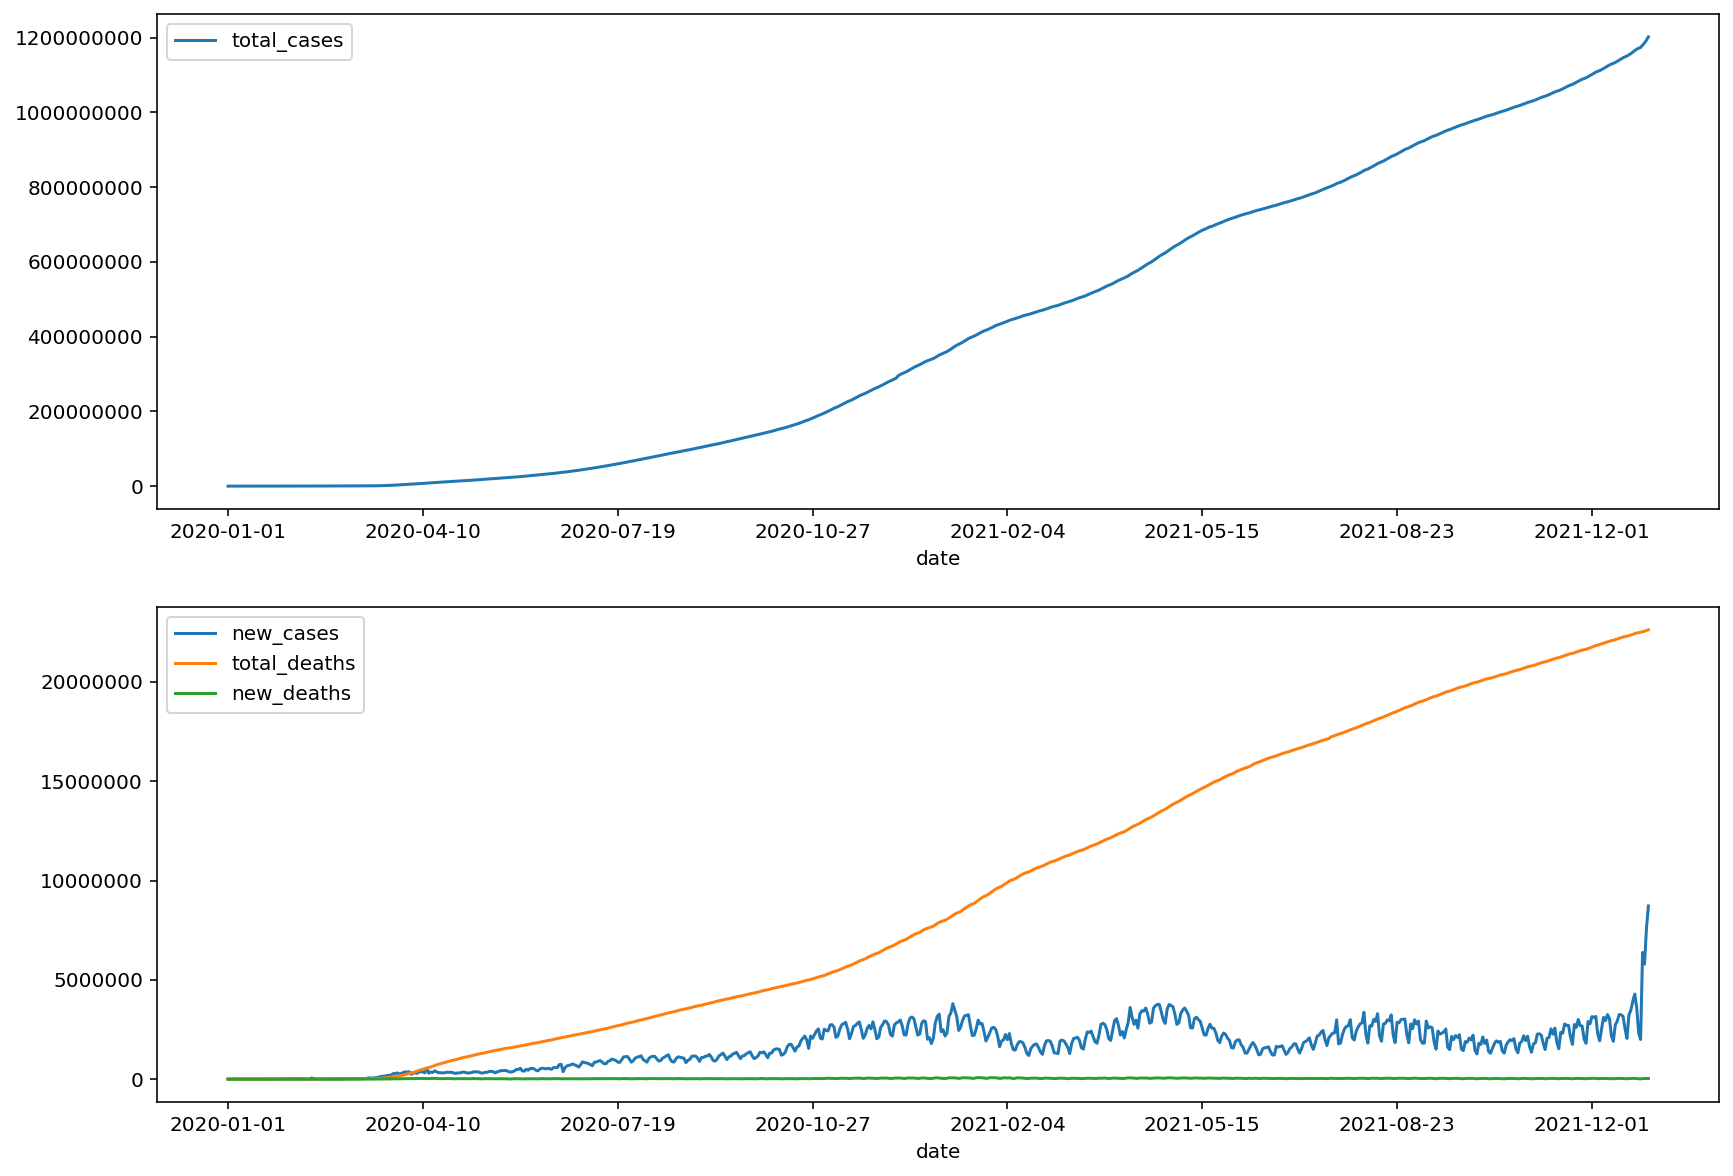

In [69]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
# 전세계 코로나 전체 확진자 수 추이
data.groupby(['date'])['total_cases'].sum().plot(kind='line', ax=ax1, legend='total_cases', title='')
# 전세계 코로나 신규 확진자 수(daily), 전체 사망자 수(daily), 신규 사망자 수(daily)
data.groupby(['date'])['new_cases'].sum().plot(kind='line', ax=ax2, legend='new_cases')
data.groupby(['date'])['total_deaths'].sum().plot(kind='line', ax=ax2, legend='total_deaths')
data.groupby(['date'])['new_deaths'].sum().plot(kind='line', ax=ax2, legend='new_deaths')
ax1.get_yaxis().get_major_formatter().set_scientific(False)
ax2.get_yaxis().get_major_formatter().set_scientific(False)

####total_vaccinations, people_vaccinated, people_fully_vaccinated, new_vaccinations, total_boosters

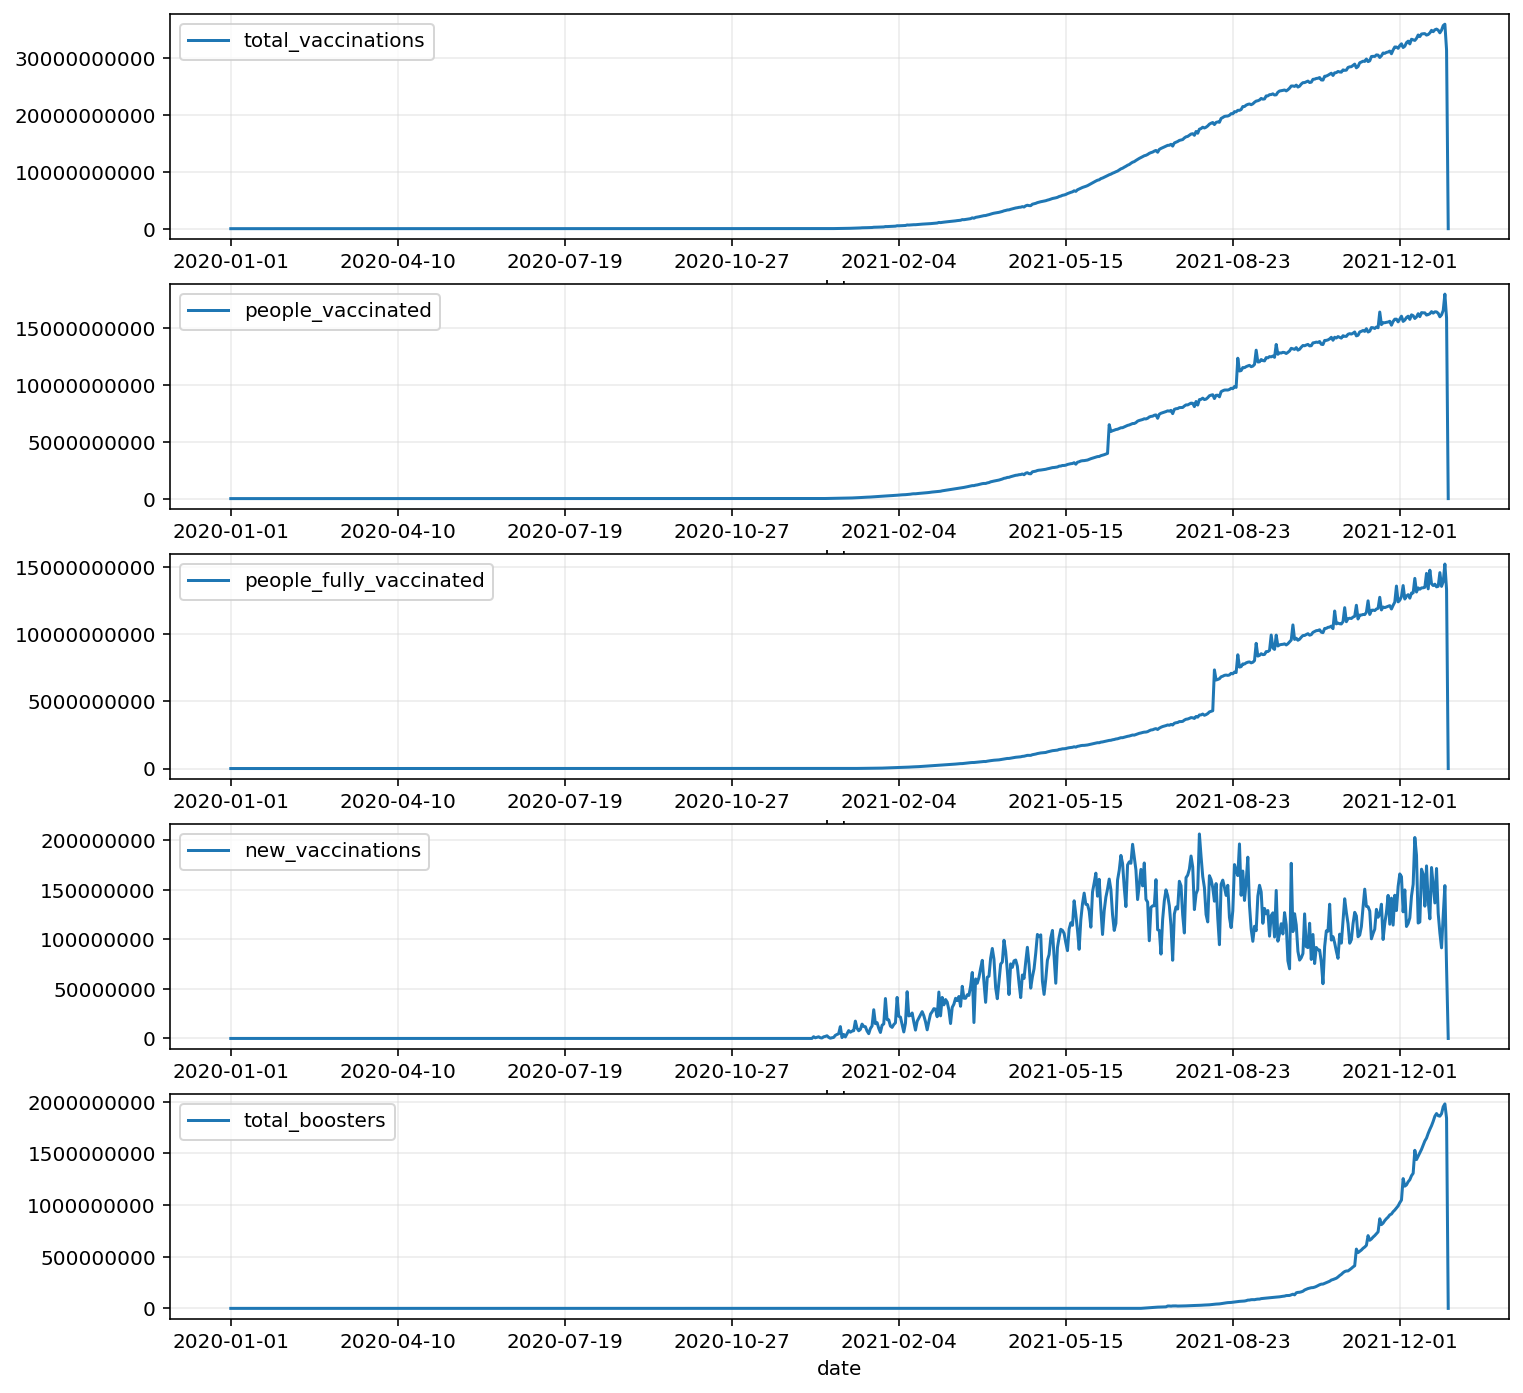

In [79]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 12))
li = ['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations', 'total_boosters']
ax = [ax1, ax2, ax3, ax4, ax5]

for (col, ax) in zip(li, ax):
    
    data.groupby(['date'])[col].sum().plot(kind='line', ax=ax, legend='col')
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.grid(color='lightgrey', alpha=0.43)

* 백신 관련 그래프들의 공통점
    * 전체 기간 중 마지막 날에 추세가 뚝 떨어짐 -> 확인 필요

In [83]:
col = ['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations', 'total_boosters']

for i in col:
    print(f"{i} 컬럼의 전체 기간 중 마지막 3일 가져오기")
    display(data.groupby(['date'])[i].sum().tail(3))
    print('\n')

total_vaccinations 컬럼의 전체 기간 중 마지막 3일 가져오기


date
2021-12-28   36019228287.00
2021-12-29   31484423322.00
2021-12-30             0.00
Name: total_vaccinations, dtype: float64



people_vaccinated 컬럼의 전체 기간 중 마지막 3일 가져오기


date
2021-12-28   17954188701.00
2021-12-29   15858884351.00
2021-12-30             0.00
Name: people_vaccinated, dtype: float64



people_fully_vaccinated 컬럼의 전체 기간 중 마지막 3일 가져오기


date
2021-12-28   15204129824.00
2021-12-29   13311223116.00
2021-12-30             0.00
Name: people_fully_vaccinated, dtype: float64



new_vaccinations 컬럼의 전체 기간 중 마지막 3일 가져오기


date
2021-12-28   154258314.00
2021-12-29    71745629.00
2021-12-30           0.00
Name: new_vaccinations, dtype: float64



total_boosters 컬럼의 전체 기간 중 마지막 3일 가져오기


date
2021-12-28   1978637737.00
2021-12-29   1839839104.00
2021-12-30            0.00
Name: total_boosters, dtype: float64

* 백신 관련 데이터들 전부 마지막 날은 전부 0 (row별로 확인해보면 모든 지역의 21년 12월 30일에 적재돼있는 데이터가 전부 null)
* 12/30에 백신 관련 외에는 확진자 수나 사망자 수가 잘 적재되어 있으므로 12/30 데이터는 일단 남겨둠
* 시각화 과정에서 12/30 데이터를 제외할 것인지 말지는 팀원분들 각자의 판단에 따라 결정하면 될 것 같음

## 데이터 저장

In [85]:
data.to_csv('/content/gdrive/MyDrive/Interactive Data Lab/covid-19/preprocessed_data.csv', index=False)

In [86]:
data.shape

(151085, 32)